# Two-body twisted boundary conditions

This notebook provides a minimal description how to implement twisted boundary conditions for a non-relativistc two-body quantum system following the publication [[1511.06598]](https://arxiv.org/abs/1511.06598v1).

## Initialization

In [1]:
# Python modules
import itertools
import time
from dataclasses import dataclass
from dataclasses import field
from typing import Dict

# Numerical modules
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as lina
import scipy.optimize as opt

# Data management
import pandas as pd

# Plotting
import matplotlib.pylab as plt
import seaborn as sns

# Fitting
import gvar as gv
import lsqfit

### Parameters

Quantities will be expressed in units of [fm]. Energies are converted to inverse fermi using $\hbar c = 197.326$ MeV/fm.

In [3]:
HBARC = 197.326 # MeV / fm
E_DEUTERON = - 2.225 / HBARC
M_NUCLEON = (938.27 + 939.57) / 2 / HBARC

NDIM_MAX = 3
N1D_MAX = 20
LATTICE_SPACING = 1.97

# Introduction

This notebook implements a lattice Hamiltonian with a simple contact interaction and twisted boundary conditions
The numerical derivatives are implementend using the "twist at each hop" method described in [[1511.06598]](https://arxiv.org/abs/1511.06598v1).

In the later parts of the notebook, the eigenvalues of the Hamiltonian are computed for different volumes and different boundary conditions.

### Kinetic Hamiltonian

The implementation of the kinetich Hamiltonian is the crucial part for the implementation of twisted boundary conditions.

In the one-dimensional case, a simple discrete 1-step derivative for twisted boundary conditions is given by
$$
    \frac{d^2 f(x = n \epsilon)}{dx^2} 
    \rightarrow \frac{1}{\epsilon^2}
    \left[ 
        f(n\epsilon + \epsilon) e^{i \phi \epsilon/ L } 
        - 2 f(n\epsilon) 
        + f(n\epsilon - \epsilon) e^{-i \phi \epsilon/ L } 
    \right] \, ,
$$
where $\epsilon$ is the lattice spacing, $\phi$ the twist angle and $L$ the size of the volume.

For improved discrete derivative implementations (n-steps) see also [Finite difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient).

The kinetic Hamiltonian in relative coordinates is computed by dividing the above expression by two times the reduced mass of the subsystem &mdash; in the case of equal mass particles, half the mass of individual particles.

The below implementation of the kinetic Hamiltonian is general in the number of dimensions and the implementation of the derivative.
This is achieved by creating a meta index for coordinates:
```python
nr = n1 + n2 * n1d_max ** 1 + n3 * n1d_max ** 2 + ...
```
where `ni` describe the index in each respective dimension.

Taking the derivative in a respective direction adjusts the `ni` components.
Because the grid is finite with boundary conditions, all `ni` are identified with their `n1d_max` modulus. 

For example, when shifitng the y-coordinate in a three dimensional space by one lattice spacing becomes
```
nr_yshift = nx + ((ny + 1) % n1d_max) * n1d_max ** 1 + nz * n1d_max ** 2
```

The below kinetic Hamiltonian iterates over all dimensions and shifts to create a `n_max x n_max` matrix with `n_max = n1d_max ** ndim_max`.

In [4]:
def get_kinetic_hamiltonian(
    n1d_max: int,
    twist_angle: float = 0.0,
    lattice_spacing: float = 1.0,
    particle_mass: float = M_NUCLEON,
    ndim_max: int = 3,
    derivative_shifts: Dict[int, float] = {-1: 1.0, 0: -2.0, 1: 1.0},
) -> sp.csr_matrix:
    """Computes the kinetic Hamiltonian for a relative two-body system in a 3D box.
    
    The kinetic Hamiltonian is defined by
        `H0 = - Laplace / 2 /(particle_mass/2)` 
    Where Laplace is the lattice laplace operator with twisted boundary conditions.
    
    The function uses scipy sparse matrices in column format.
    
    Arguments
    ---------
        n1d_max: int
            Spatial dimension of lattice in any direction.
        
        twist_angle: float
            The total amount of twist.
            
        lattice_spacing: float
            The lattice spacing in fermi.
            
        particle_mass: float
            The mass of the particles to be described in inverse fermi.
        
        ndim_max: float
            The number of spatial dimensions.
        
        derivative_shifts: Dict[int, float]
            The implementation of the numerical laplace operator.
            E.g., for a one step derivative 
                `d2f/dx2(n) = sum(
                    c_i * f(n + s_i) * exp(1j * twist_angle/n1d_max * s_i)
                )/lattice_spacing**2`
            where s_i and c_i are the keys and values of derivative_shifts.
            
            
    """
    data = sp.lil_matrix((n1d_max ** ndim_max, n1d_max ** ndim_max), dtype=complex)

    h0_fact = 1 / lattice_spacing ** 2 / 2 / (particle_mass / 2)

    modified_shifts = {
        shift: coeff * h0_fact * np.exp(1j * twist_angle / n1d_max * shift)
        for shift, coeff in derivative_shifts.items()
    }

    for nr in range(n1d_max ** ndim_max):
        nr_subtracted = nr
        n1d_pow_ndim = 1

        for ndim in range(ndim_max):
            nxi = (nr_subtracted % (n1d_pow_ndim * n1d_max)) // n1d_pow_ndim
            nr_subtracted -= nxi * n1d_pow_ndim

            for shift, coeff in modified_shifts.items():
                nr_shift = nr + n1d_pow_ndim * (
                    -nxi + (nxi + shift + n1d_max * 10) % n1d_max
                )
                data[(nr, nr_shift)] -= coeff

            n1d_pow_ndim *= n1d_max

    return data.tocsr()


### Cross check

Here, a few cross checks for the kinetic Hamiltonian are implemented.

In [5]:
n1d = 4
ndim = 2
twist = 0.1 * np.pi
shifts = {-1: 1.0, 0: -2.0, 1: 1.0}

H0 = get_kinetic_hamiltonian(
    n1d_max=n1d, ndim_max=ndim, twist_angle=twist, derivative_shifts=shifts, lattice_spacing=LATTICE_SPACING
).toarray()

#### Test if operator is hermitean

In [6]:
np.testing.assert_equal(H0, H0.T.conj())

#### Test eigenvalues of the operator

The eigenvlues of the discrete kinetic Hamiltonian are given by
$$
    E(\vec p) = - \frac{1}{M_N \epsilon^2}\left[
        \sum_{n_d = 1}^{n_{dim}}
        \sum_{n_s = - n_{step}}^{n_{step}}
        c_{n_s} \cos( p_{n_d}  n_{step} \epsilon )
    \right] \, ,
$$

where $p_L$ are the lattice momenta defined by
$$
    p_{n_d}(\vec n, \vec \phi)
    =
    \frac{2 \pi n_{n_d}}{L} + \frac{\phi_{n_d} }{L}
    \, .
$$

The vector $\vec n$ runs over all allowed lattice grid points.

In [7]:
L = n1d * LATTICE_SPACING

energies = []

for n in itertools.product(*[range(n1d)] * ndim):
    En = 0
    for ni in n:
        pi = 2 * np.pi * ni / L + twist / L

        for nstep, coeff in shifts.items():
            En -= coeff * np.cos(pi * nstep * LATTICE_SPACING)

    energies.append(En)

energies = np.array(energies) / M_NUCLEON / LATTICE_SPACING ** 2

eigs, vecs = np.linalg.eigh(H0)

# Sort to enable comparism
energies.sort()
eigs.sort()

np.testing.assert_allclose(energies, eigs)

## Potential

To simplify the analysis, the potential is a simple contact interaction
$$
    V(r) = c \delta(r) \, .
$$
For the sake of simplicity, the lattice spacing in discrete space is absorbed in the definition of $c$ (no analysis of discretization effects).

In [8]:
def get_full_hamiltonian(
    kinetic_hamiltonian: sp.csr_matrix, contact_strength: float
) -> sp.csr_matrix:
    """Copies the kinetic Hamiltonian and subtracts contact_strength from the (0, 0) component.
    
    Computes `H = H0 + V`, where `V = contact_strength * delta(nr, 0)` and `nr` is ther relative
    distance in the two particle system.
    
    Arguments
    ---------
        kinetic_hamiltonian: sparse matrix
            The kinetic two-body lattice Hamiltonian.
            
        contact_strength: float
            The strength of the contact interaction in respective units.
            This depends on the dimension of the problem, e.g., [fm]**(-1 - ndim).
    """
    hamiltonian = kinetic_hamiltonian.copy()
    hamiltonian[0, 0] += contact_strength
    return hamiltonian


## Solver

To further simplify computations, a solver class is provided.
Once a system is initialized for given parameters, one can extract the groundstate using `solver.get_ground_state(contact_strength)`.

In [9]:
@dataclass
class Solver:
    """Solver for fast eigenvalue access depending on contact interaction strength.
    """

    n1d_max: int
    twist_angle: float = 0.0
    lattice_spacing: float = 1.0
    particle_mass: float = M_NUCLEON
    ndim_max: int = 3
    derivative_shifts: Dict[int, float] = field(
        default_factory=lambda: {
            -4: -1.0 / 560.0,
            -3: 8.0 / 315.0,
            -2: -1.0 / 5.0,
            -1: 8.0 / 5.0,
            +0: -205.0 / 72.0,
            +1: 8.0 / 5.0,
            +2: -1.0 / 5.0,
            +3: 8.0 / 315.0,
            +4: -1.0 / 560.0,

        }
    )
    kinetic_hamiltonian: sp.lil_matrix = field(init=False, repr=False)

    def __post_init__(self):
        self.kinetic_hamiltonian = get_kinetic_hamiltonian(
            self.n1d_max,
            self.twist_angle,
            self.lattice_spacing,
            self.particle_mass,
            self.ndim_max,
            self.derivative_shifts,
        )

    def get_ground_state(self, contact_strength: float, **kwargs) -> float:
        """Returns smallest algebraic eigenvalue in of Hamiltonian in `[fm]`
        
        Arguments
        ---------
            contact_strength: float
                The strength of the contact interaction in respective units.
                This depends on the dimension of the problem, e.g., [fm]**(-1 - ndim).
                
            kwargs:
                Additional keyword arguments passed to `eigsh` solver.
        """
        H = get_full_hamiltonian(self.kinetic_hamiltonian, contact_strength)
        return lina.eigsh(H, k=1, which="SA", **kwargs)[0][0]


## Fit to deuteron binding energy

Since there is one free parameter, the strength of the contact interaction, one must provide one condition to fix the system.
In this case, in the infinte volume, the system ground state energx reproduce the deuteron binding energy.
Thus, thee contact interaction strength `C0` is fitted to binding energies at large volumes (`N1D_INF`).

Repeating eigenvalue computations for smaller volumes with the fixed `C0` returns the binding energy for finite lattices `E_L`.

In [10]:
N1D_INF = N1D_MAX // 2 * 3

### Numerical accelerator

The ground state wave function is of the form
$$
    f(r) \sim \frac{\exp\{-\kappa r\}}{r} \, , \quad \kappa^2 = M_N | E_B| \, .
$$
This information can be used to accelerate the computation by making an educated guess for the ground state:

In [11]:
N1D_INF = N1D_MAX // 2 * 3

In [12]:
r = []
for nxi in itertools.product(*[range(N1D_INF)] * NDIM_MAX):
    r.append(np.sqrt(np.sum(np.array(nxi) ** 2)) * LATTICE_SPACING)
r = np.array(r)

kappa = np.sqrt(M_NUCLEON * abs(E_DEUTERON))

psi0 = np.exp(-kappa * r) / (r + 1.e-7)
psi0 /= np.sqrt(psi0 @ psi0)

### Run the fit

**This might take a while**

Minimize $ f(c) = (E_L(c) - E_D)^2 $.

In [13]:
solver = Solver(n1d_max=N1D_INF, ndim_max=NDIM_MAX, lattice_spacing=LATTICE_SPACING)
res = opt.minimize(
    lambda c: (solver.get_ground_state(c, v0=psi0) - E_DEUTERON) ** 2, -10.0
)
C0 = res.x[0]

H = get_full_hamiltonian(solver.kinetic_hamiltonian, C0)
fitted_ground_state = lina.eigsh(H, k=1, which="SA")[0][0] * HBARC

print(f"Contact strength: {C0:1.4e} with ground state {fitted_ground_state:1.3f} [MeV]")

Contact strength: -3.1677e-01 with ground state -2.225 [MeV]


## Twist computation

Here, the computations are repeated for fixed `C0` but different twist angles and volumes.

The quantitites of interest are the finite volume ground state energy `E_L`.

In [14]:
data = []

for n1d in range(2, N1D_MAX, 2):
    for twist_angle in np.linspace(0, 2 * np.pi, 21):
        solver = Solver(
            n1d_max=n1d,
            ndim_max=NDIM_MAX,
            lattice_spacing=LATTICE_SPACING,
            twist_angle=twist_angle,
        )

        t_start = time.time_ns()
        EL = solver.get_ground_state(C0)
        t_end = time.time_ns()

        data.append(
            {
                "E_L": EL * HBARC,
                "n1d": n1d,
                "twist_angle": twist_angle / np.pi,
                "L": n1d * LATTICE_SPACING,
                "cpu_time": (t_end - t_start) / 10 ** 9,
            }
        )

df = pd.DataFrame(data)

df.head()

,E_L,L,cpu_time,n1d,twist_angle
0,-14.640227,3.94,0.002033,2,0.0
1,-13.987134,3.94,0.002042,2,0.1
2,-12.051531,3.94,0.000929,2,0.2
3,-8.912811,3.94,0.000912,2,0.3
4,-4.734482,3.94,0.001041,2,0.4


### Plot the finite volume convergence

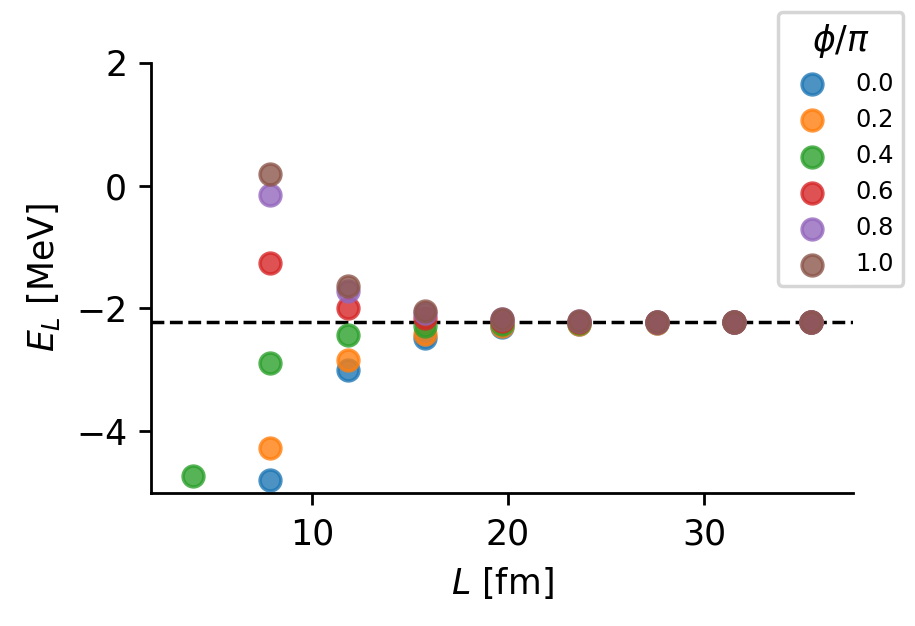

In [15]:
selected_fits = df.where((df.twist_angle * 10) % 2 != 1).query("twist_angle <= 1.0")

g = sns.lmplot(
    x="L",
    y="E_L",
    hue="twist_angle",
    data=selected_fits,
    fit_reg=False,
    legend=False,
    height=2.5,
    aspect=1.5,
)

g.set_axis_labels("$L$ [fm]", "$E_L$ [MeV]")
g.fig.set_dpi(250)
g.fig.legend(title="$\phi / \pi$", loc="upper right", fontsize="x-small")

g.ax.axhline(E_DEUTERON * HBARC, ls="--", color="black", zorder=-1, lw=1)
g.ax.set_ylim(-5, 2)

plt.show(g)

## Fitting

Different to the fitting method defined in the paper, this notebook uses a bayesian approach using Peter Lepages [`lsqfit`](https://github.com/gplepage/lsqfit).

### Fit setup

The fitting function is of the form

$$
    E_L(L; E_0, A^{(LO)}, A_1^{(NLO)}, A_2^{(NLO)}, A_1^{(N2LO)})
    =
    E_0
    + A^{(LO)} \frac{e^{-\kappa L}}{\kappa L}
    + A_1^{(NLO)} \frac{e^{-\sqrt{2}\kappa L}}{\kappa L}
    + A_2^{(NLO)} \frac{e^{-\kappa L}}{\kappa^2 L^2}
    + A_1^{(N2LO)} \frac{e^{-2\kappa L}}{\kappa L}
    \, ,
$$
where $ \kappa(E_0) = \sqrt{- E_0 M_N}$.

The prior of the parameters is chosen broadly to affect the posterior of the fit parameters in a minimal way (standard deviation is way larger than outcome standard deviation).

In [16]:
def multi_exp(L: "array", pars: Dict[str, "GVar"]) -> "GVar":
    """Implents the multi-exponential fit function.
    
    Arguments
    ---------
        L: array
            The size of the finite volume in one dimension in [fm].
            
        pars: Dict[str, "GVar"]
            The input parameters for the fit. The dictionary must contain
            the keys `E0`, `A_LO`, `A1_NLO`, `A2_NLO` and `A1_N2LO`.
            The unit of all parameters are [MeV].
    """
    y = pars["E0"]

    kappa = gv.sqrt(-pars["E0"] / HBARC * M_NUCLEON)
    y += pars["A_LO"] * gv.exp(-kappa * L) / L / kappa
    y += pars["A1_NLO"] * gv.exp(-kappa * np.sqrt(2) * L) / L / kappa
    y += pars["A2_NLO"] * gv.exp(-kappa * L) / L ** 2 / kappa ** 2
    y += pars["A1_N2LO"] * gv.exp(-kappa * 2 * L) / L / kappa
    return y


def make_prior() -> "GVar":
    """Creates an example prior for fitting the `multi_exp` function defined above.
    """
    return {
        "E0": gv.gvar(-3.0, 5.0),
        "A_LO": gv.gvar(0.0, 100.0),
        "A1_NLO": gv.gvar(0.0, 200.0),
        "A2_NLO": gv.gvar(0.0, 200.0),
        "A1_N2LO": gv.gvar(0.0, 200.0),
    }


### Run the fits

In [17]:
fit_res = []

for twist_angle in df.twist_angle.unique():
    fit_data = df.query("twist_angle == @twist_angle")
    
    energy_numerical_err = [0.002] * fit_data.E_L.values.size

    res = lsqfit.nonlinear_fit(
        data=(
            fit_data.L.values,
            gv.gvar(fit_data.E_L.values, energy_numerical_err),
        ),
        fcn=multi_exp,
        prior=make_prior(),
    )
    res.p["twist_angle"] = twist_angle
    res.p["chi2dof"] = res.chi2 / res.dof
    fit_res.append(res.p)
    
fit_df = pd.DataFrame(fit_res)
fit_df

,A1_N2LO,A1_NLO,A2_NLO,A_LO,E0,chi2dof,twist_angle
0,68(20),34.0(4.0),-41.9(7.1),-33.1(2.6),-2.2242(12),0.163671,0.0
1,65(20),31.1(4.0),-39.2(7.1),-31.1(2.6),-2.2243(12),0.133953,0.1
2,53(20),23.7(4.1),-31.2(7.1),-25.7(2.6),-2.2245(12),0.072246,0.2
3,35(20),14.7(4.1),-19.1(7.1),-18.2(2.6),-2.2248(12),0.025049,0.3
4,15(20),6.5(4.1),-6.1(7.1),-9.6(2.6),-2.2250(12),0.006422,0.4
5,5(20),-1.0(4.1),4.4(7.1),-0.7(2.6),-2.2251(12),0.002953,0.5
6,7(20),-9.7(4.2),12.0(7.2),7.8(2.6),-2.2250(12),0.004263,0.6
7,14(20),-20.2(4.2),18.8(7.2),15.1(2.6),-2.2250(11),0.008532,0.7
8,22(20),-30.3(4.2),24.5(7.2),20.6(2.6),-2.2249(11),0.014900,0.8
9,27(20),-37.2(4.2),27.9(7.2),24.1(2.6),-2.2249(11),0.020714,0.9


### Extrapolated binding energy depending on twist angle

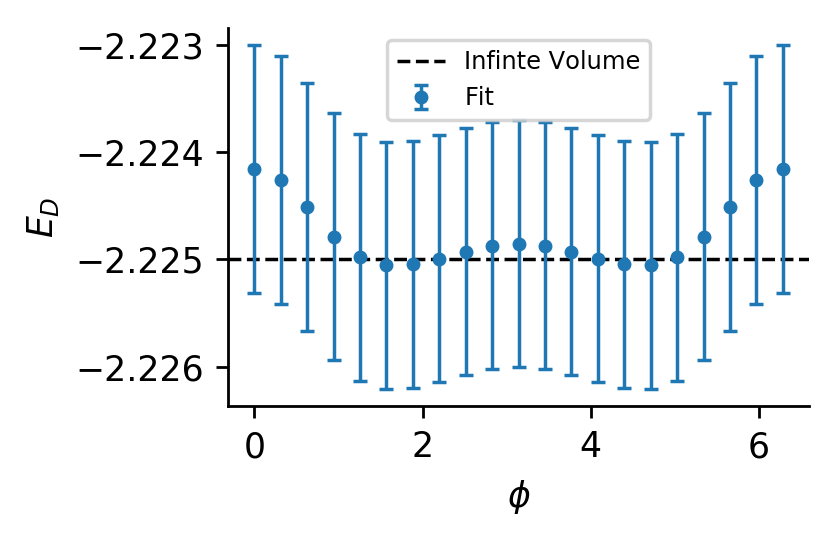

In [18]:
angles = fit_df.twist_angle * np.pi

fig, ax = plt.subplots(figsize=(3, 2), dpi=250)

ax.errorbar(
    angles,
    gv.mean(fit_df.E0.values),
    gv.sdev(fit_df.E0.values),
    marker=".",
    ls="None",
    capsize=2,
    lw=1,
    label="Fit",
)

ax.axhline(
    E_DEUTERON * HBARC, ls="--", color="black", zorder=-1, lw=1, label="Infinte Volume"
)

ax.legend(loc="upper center", fontsize="x-small")
ax.set_ylabel("$E_D$")
ax.set_xlabel("$\phi$")

sns.despine()

plt.show(fig)

### Extracted leading FV energy shift amplitude depending on twist angle

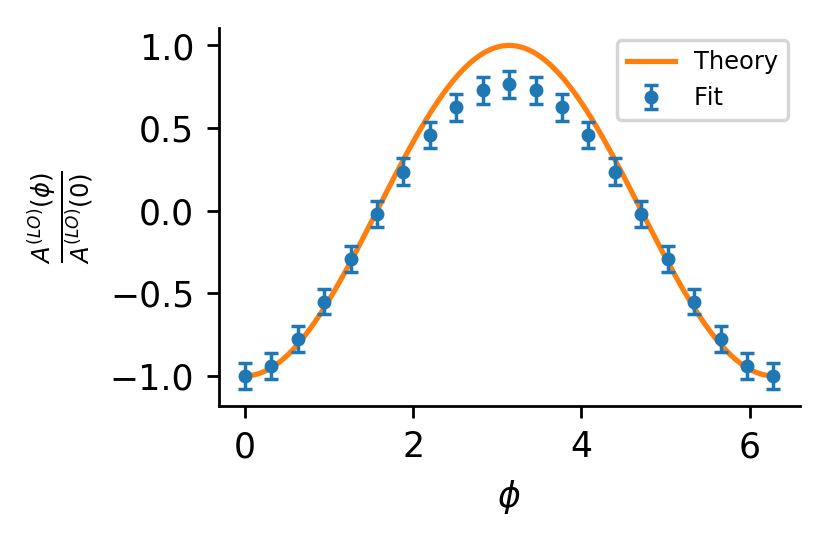

In [19]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=250)

ax.errorbar(
    angles,
    -gv.mean(fit_df.A_LO.values) / gv.mean(fit_df.A_LO.iloc[0]),
    gv.sdev(fit_df.A_LO.values) / gv.mean(fit_df.A_LO.iloc[0]),
    marker=".",
    ls="None",
    capsize=2,
    lw=1,
    label="Fit",
)

phi_grid = np.linspace(0, np.pi * 2, 100)
ax.plot(phi_grid, -np.cos(phi_grid), label="Theory", zorder=-1)

ax.legend(loc="upper right", fontsize="x-small")
ax.set_ylabel(r"$\frac{A^{(LO)}(\phi)}{A^{(LO)}(0)}$")
ax.set_xlabel("$\phi$")

sns.despine()

plt.show(fig)

## Discussion

See [[1511.06598]](https://arxiv.org/abs/1511.06598v1) section IV and following.